In [1]:
from __future__ import print_function
%matplotlib inline  
import matplotlib.pyplot as plt

import cv2
import numpy as np
import os

In [2]:
class DataSource(object):
    def __init__(self, imageSource, path=''):
        print('Reading images.')
        self.readImages(imageSource, path)
        print('Reading images --- DONE.')
        
    def readImages(self, imageSource, path=''):
        self.images = []
        with open(imageSource, 'r') as f:
            for line in f:
                line = line.strip()
                try:
                    image = cv2.imread(os.path.join(path, line) + '_RGB.png')
                    labelMask  = cv2.imread(os.path.join(path, line) + '_label.tif')
                    labelMask = np.uint8(labelMask > 128)
                    labelMask = labelMask[:,:,0] + labelMask[:,:,1] * 2 + labelMask[:,:,2] * 4
                    self.images.append((image, labelMask))
                except:
                    print('ERROR: Unable to read image or label file', os.path.join(path, line))
                

    def upateCrops(self, resolution=128, sDev=0.05, cropsPerImage=200):
        self.crops = []
        for image, labels in self.images:
            for i in range(cropsPerImage):
                while(True):
                    dst = np.array([
                        [0, 0],
                        [resolution - 1, 0],
                        [resolution - 1, resolution - 1],
                        [0, resolution - 1]], dtype=np.float32)

                    # center the source patch around 0
                    src = dst - resolution / 2

                    # random patch rotation
                    angle = np.random.uniform() * np.pi * 2
                    R = np.array([
                        [np.cos(angle), -np.sin(angle)],
                        [np.sin(angle),  np.cos(angle)]
                        ], dtype=np.float32)
                    src = src.dot(R)   

                    # Shift the crop.
                    position = np.array([
                        [np.random.randint(image.shape[1]), np.random.randint(image.shape[0])]
                        ], dtype=np.float32)
                    src += position

                    # add small random corner position noise
                    noise = resolution * sDev * np.random.normal(size=dst.shape).astype(np.float32)
                    src = src + noise

                    if np.all(src >= 0) and np.all(src[:, 1] < image.shape[0]) and np.all(src[:, 0] < image.shape[1]):
                        break

                if not (np.all(src >= 0) and np.all(src[:, 1] < image.shape[0]) and np.all(src[:, 0] < image.shape[1])):
                    print("BLody fail.")
                # compute transformation
                T = cv2.getPerspectiveTransform(src, dst)
                croppedImage = cv2.warpPerspective(  # interpolate image
                    image, T, (resolution, resolution),
                    flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
                
                
                croppedLabels = cv2.warpPerspective(  # DON'T interpolate labels
                    labels, T, (resolution, resolution),
                    flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT)

                self.crops.append((croppedImage, croppedLabels[:, :, np.newaxis], src))
                    
    def getBatch(self, count=32):
        idx = np.random.choice(len(self.images), count)
        data = [self.crops[i][0] for i in idx]
        labels = [self.crops[i][1] for i in idx]
        data = np.stack(data)
        labels = np.stack(labels)
        
        return data, labels
    
    def getAllCrops(self):
        
        data = [c[0] for c in self.crops]
        labels = [c[1] for c in self.crops]
        data = np.stack(data)
        labels = np.stack(labels)
        
        return data, labels

In [3]:
sourceTrn = DataSource('files.trn', path='')
sourceVal = DataSource('files.tst', path='')
sourceTrn.upateCrops(resolution=128, sDev=0.05, cropsPerImage=20)

Reading images.
Reading images --- DONE.
Reading images.
Reading images --- DONE.


In [4]:
i=0

[[ 449.59146118  465.05001831  575.74841309  575.72717285]
 [ 582.34753418  450.16619873  458.43762207  578.89880371]] (128, 128, 3)


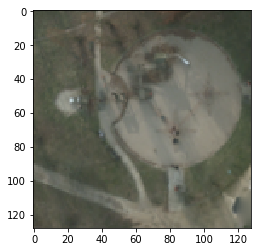

In [6]:

plt.imshow(sourceTrn.crops[i][0][:, :, ::-1])
print(sourceTrn.crops[i][2].T, sourceTrn.crops[i][0].shape)
i+=1


In [7]:
from keras.layers import Input, Reshape, Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Activation, Conv2D, MaxPooling2D, PReLU, UpSampling2D
from keras.layers import Concatenate
from keras.models import Model
from keras import regularizers

Using TensorFlow backend.


In [8]:
from keras.layers import Reshape
def build_VGG_block(net, channels, layers, prefix):
    for i in range(layers):
        net = Conv2D(channels, 3, activation=PReLU(shared_axes=[1, 2]), padding='same',
                    name='{}.{}'.format(prefix, i))(net)
    return net

def build_VGG_Bnorm_block(net, channels, layers, prefix):
    for i in range(layers):
        net = Conv2D(channels, 3, padding='same',
                    name='{}.{}'.format(prefix, i))(net)
        net = BatchNormalization()(net)
        net = PReLU(shared_axes=[1, 2])(net)
    return net

def build_hourglass(input_data, block_channels=[16, 32, 64], block_layers=[2, 2, 3]):

    net = input_data
    bypasses = []
    for i, (cCount, lCount) in enumerate(zip(block_channels, block_layers)):
        net = build_VGG_Bnorm_block(net, cCount, lCount, 'conv{}'.format(i))
        if i != len(block_channels)-1:
            bypasses.append(net)
            net = MaxPooling2D(2, 2, padding="same")(net)
        net = Dropout(rate=0.2)(net)
        
    bypasses = list(reversed(bypasses))

    for i, (cCount, lCount) in enumerate(zip(reversed(block_channels), reversed(block_layers))):
        if i > 0:
            net = UpSampling2D(size=(2, 2))(net)
            net = Concatenate()([net, bypasses[0]])
            bypasses = bypasses[1:]
        net = build_VGG_Bnorm_block(net, cCount, lCount, 'decoder_conv{}'.format(i))
        
    net = Conv2D(8, 3, activation='softmax', padding='same', name='classProb')(net)
    net = Reshape((-1, 8))(net)
    return net

In [9]:
from keras import optimizers
from keras.models import Model
from keras import losses
from keras import metrics

input_data = Input(shape=(128, 128, 3), name='data')
net = build_hourglass(input_data, block_channels=[24,48,48,48], block_layers=[2,2,2,3])
model = Model(inputs=[input_data], outputs=[net])

print('Model')
model.summary()

model.compile(
    loss=losses.sparse_categorical_crossentropy, 
    optimizer=optimizers.Adam(lr=0.001), 
    metrics=[metrics.sparse_categorical_accuracy])

Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv0.0 (Conv2D)                (None, 128, 128, 24) 672         data[0][0]                       
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 24) 96          conv0.0[0][0]                    
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 128, 128, 24) 24          batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv

In [10]:
sourceVal.upateCrops(resolution=128, sDev=0.05, cropsPerImage=50)
val_img, val_labels = sourceVal.getAllCrops()
val_labels = val_labels.reshape(val_labels.shape[0], -1, 1)

In [ ]:
for i in range(1000):
    sourceTrn.upateCrops(resolution=128, sDev=0.05, cropsPerImage=200)
    trn_img, trn_labels = sourceTrn.getAllCrops()
    trn_labels = trn_labels.reshape(trn_labels.shape[0], -1, 1)
    model.fit(x=trn_img, y=trn_labels, batch_size=8, epochs=i+1, validation_data=[val_img, val_labels], shuffle=True, initial_epoch=i)

Train on 4200 samples, validate on 150 samples
Epoch 1/1
4200/4200 [==============================] - 26s 6ms/step - loss: 0.6770 - sparse_categorical_accuracy: 0.7443 - val_loss: 0.7700 - val_sparse_categorical_accuracy: 0.6960
Train on 4200 samples, validate on 150 samples
Epoch 2/2
4200/4200 [==============================] - 26s 6ms/step - loss: 0.6390 - sparse_categorical_accuracy: 0.7580 - val_loss: 0.8497 - val_sparse_categorical_accuracy: 0.6542
Train on 4200 samples, validate on 150 samples
Epoch 3/3
1880/4200 [============>.................] - ETA: 14s - loss: 0.6107 - sparse_categorical_accuracy: 0.7696

In [12]:
model.save_weights('model.hdf5')

In [13]:
import keras


In [14]:
input_data = Input(shape=(736, 736, 3), name='data')
net = build_hourglass(input_data,  block_channels=[24,48,48,48], block_layers=[2,2,2,3])
testModel = Model(inputs=[input_data], outputs=[net])
testModel.load_weights('model.hdf5')

(1, 736, 736, 8)


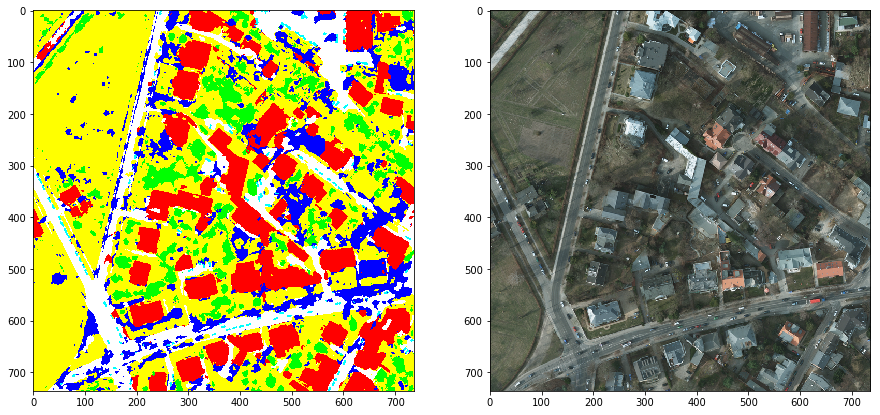

(1, 736, 736, 8)


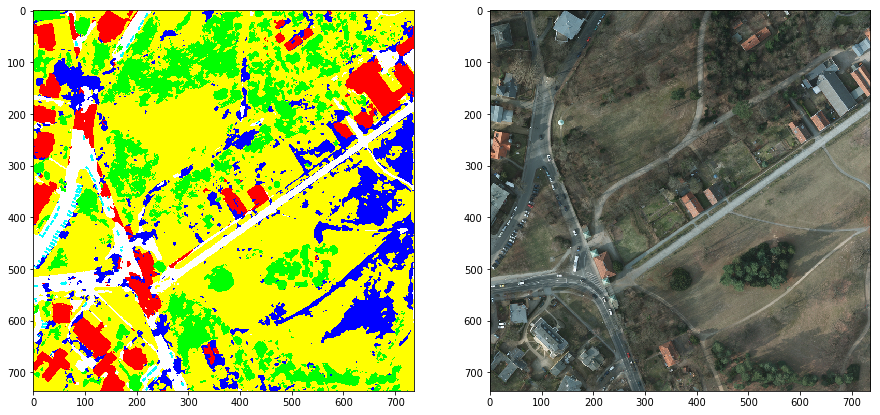

(1, 736, 736, 8)


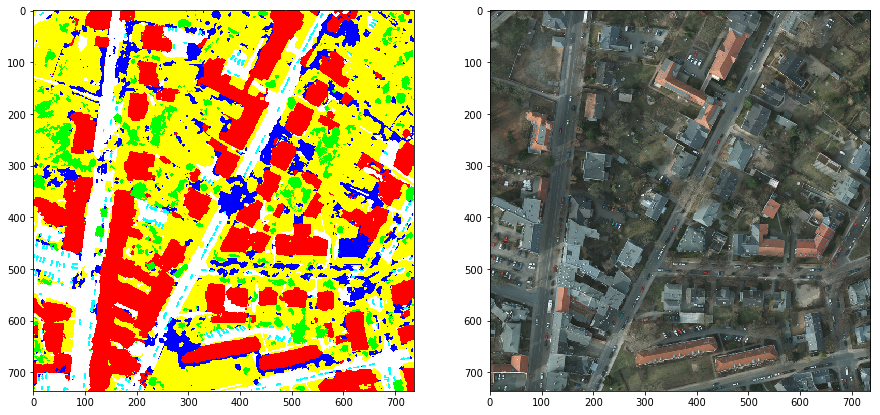

(1, 736, 736, 8)


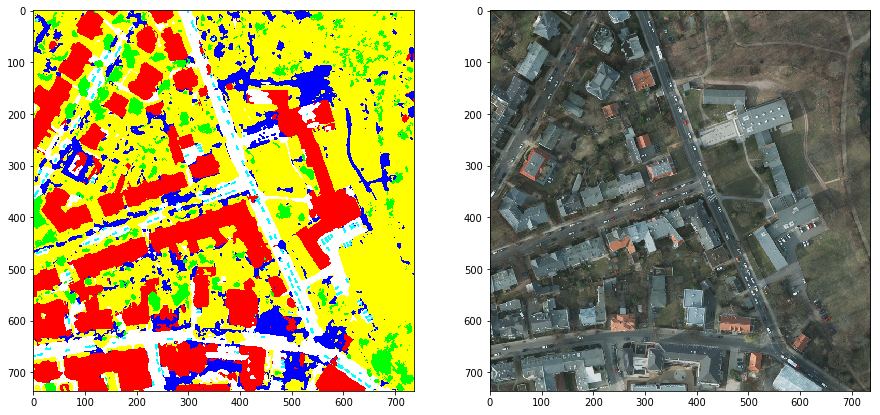

(1, 736, 736, 8)


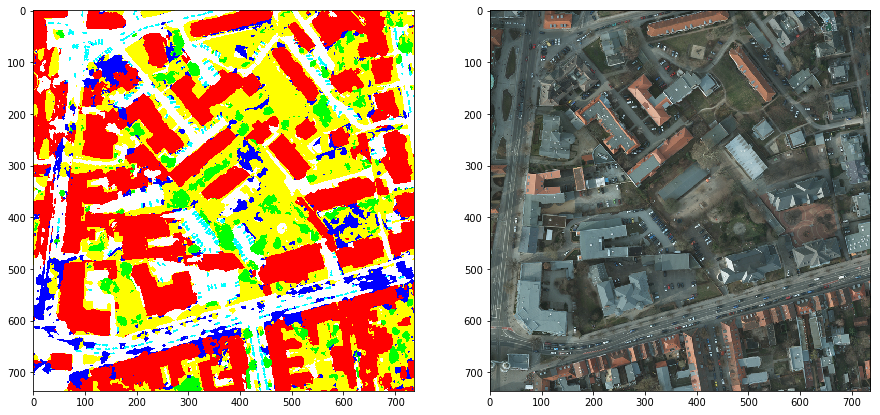

(1, 736, 736, 8)


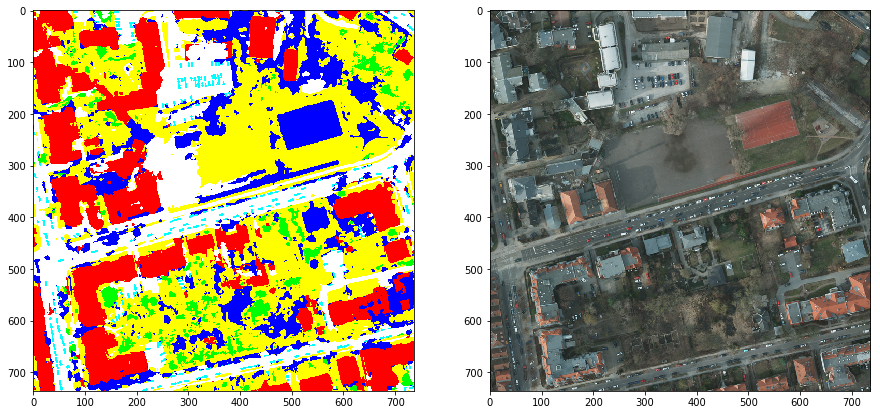

(1, 736, 736, 8)


KeyboardInterrupt: 

In [15]:


with open('./testImages.txt', 'r') as f:
    for line in f:
        line = line.strip()
        img = cv2.imread(line + '_RGB.png').astype(np.float32)[np.newaxis, :736, :736, :]
        
        out = testModel.predict(img).reshape(1, 736, 736, 8)
        print(out.shape)
        best = np.max(out, axis=3)[..., np.newaxis]
        out = out == best
        labels = np.zeros(img.shape[1:], dtype=np.uint8)
        for i in range(out.shape[3]):
            R = i % 2
            G = (i / 2) % 2
            B = (i / 4) % 2
            color = np.asarray([R,G,B]) * 255
            labels[out[0, :, :, i]] = color.reshape(1,1,3)
        plt.figure(figsize=(15,15))
        plt.subplot(1, 2, 1)
        plt.imshow(labels)
        plt.subplot(1, 2, 2)
        plt.imshow(img[0, :, :, ::-1] / 255)
        plt.show()
        
